This notebook replicates the Dynamic Time Warping analysis, in which we demonstrate a relationship between the mood rating and biomarker detection time courses. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import *
import seaborn as sns
from matplotlib import collections  as mc
import random

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [6]:
import matplotlib
matplotlib.use('agg')
sns.set_context('notebook')
from matplotlib import font_manager as fm, rcParams
print(rcParams['font.family'])
rcParams['font.family'] = 'Arial'

['sans-serif']


### load and preprocess data

Read in dataframe containing, for each day, count of biomarker detection events (`A1+A2`) and various mood scores.

In [7]:
df = pd.read_csv('data/mood_and_biomarker_events.csv')
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
# interpolated dataframe with ALL days from 10/1 to 11/29
df_i = pd.DataFrame(index = pd.date_range('10-01-2020', '11-29-2020'), columns = df.columns)
for date, row in df_i.iterrows():
    if date in df.index:
        df_i.loc[date, :] = df.loc[date, :]
# to use interpolate, need to convert columns to numeric
for col in df_i:
    df_i[col] = df_i[col].astype('float')
df_i = df_i.interpolate(method='linear')
df_i['A1+A2_norm'] = [val / np.mean(df_i['A1+A2']) for val in df_i['A1+A2']]
df_i['vas_depression_norm'] = [val / np.mean(df_i['vas_depression']) for val in df_i['vas_depression']]
df.head(10)

,A1+A2,vas_anxiety,vas_depression,hamd2_score,10 * vas_depression
date,,,,,
2020-10-01,316,21,40,12,400
2020-10-02,186,9,15,6,150
2020-10-03,577,24,32,10,320
2020-10-04,520,16,38,9,380
2020-10-06,941,13,22,6,220
2020-10-08,623,8,11,6,110
2020-10-09,377,10,9,6,90
2020-10-12,438,3,31,7,310
2020-10-13,645,7,27,6,270


<IPython.core.display.Javascript object>


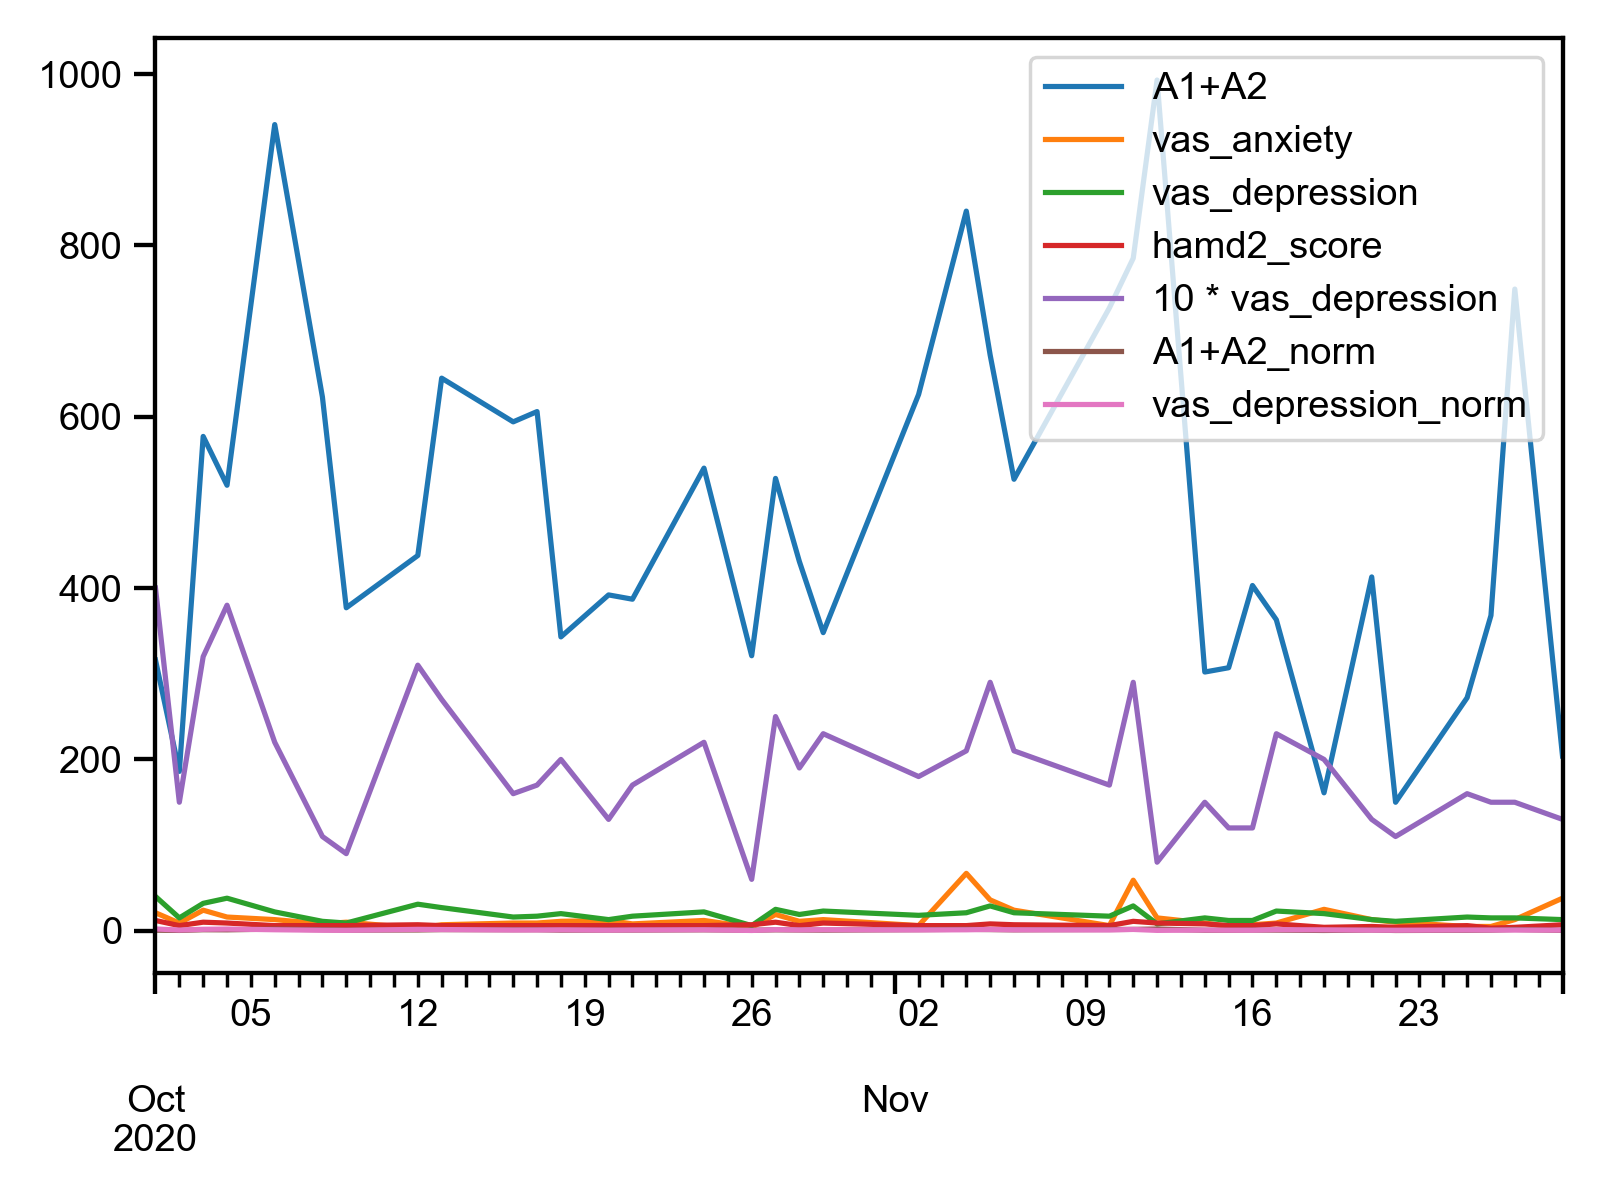

In [9]:
%matplotlib notebook
df_i.plot()
plt.tight_layout()

### visualize DTW mapping between traces

<IPython.core.display.Javascript object>


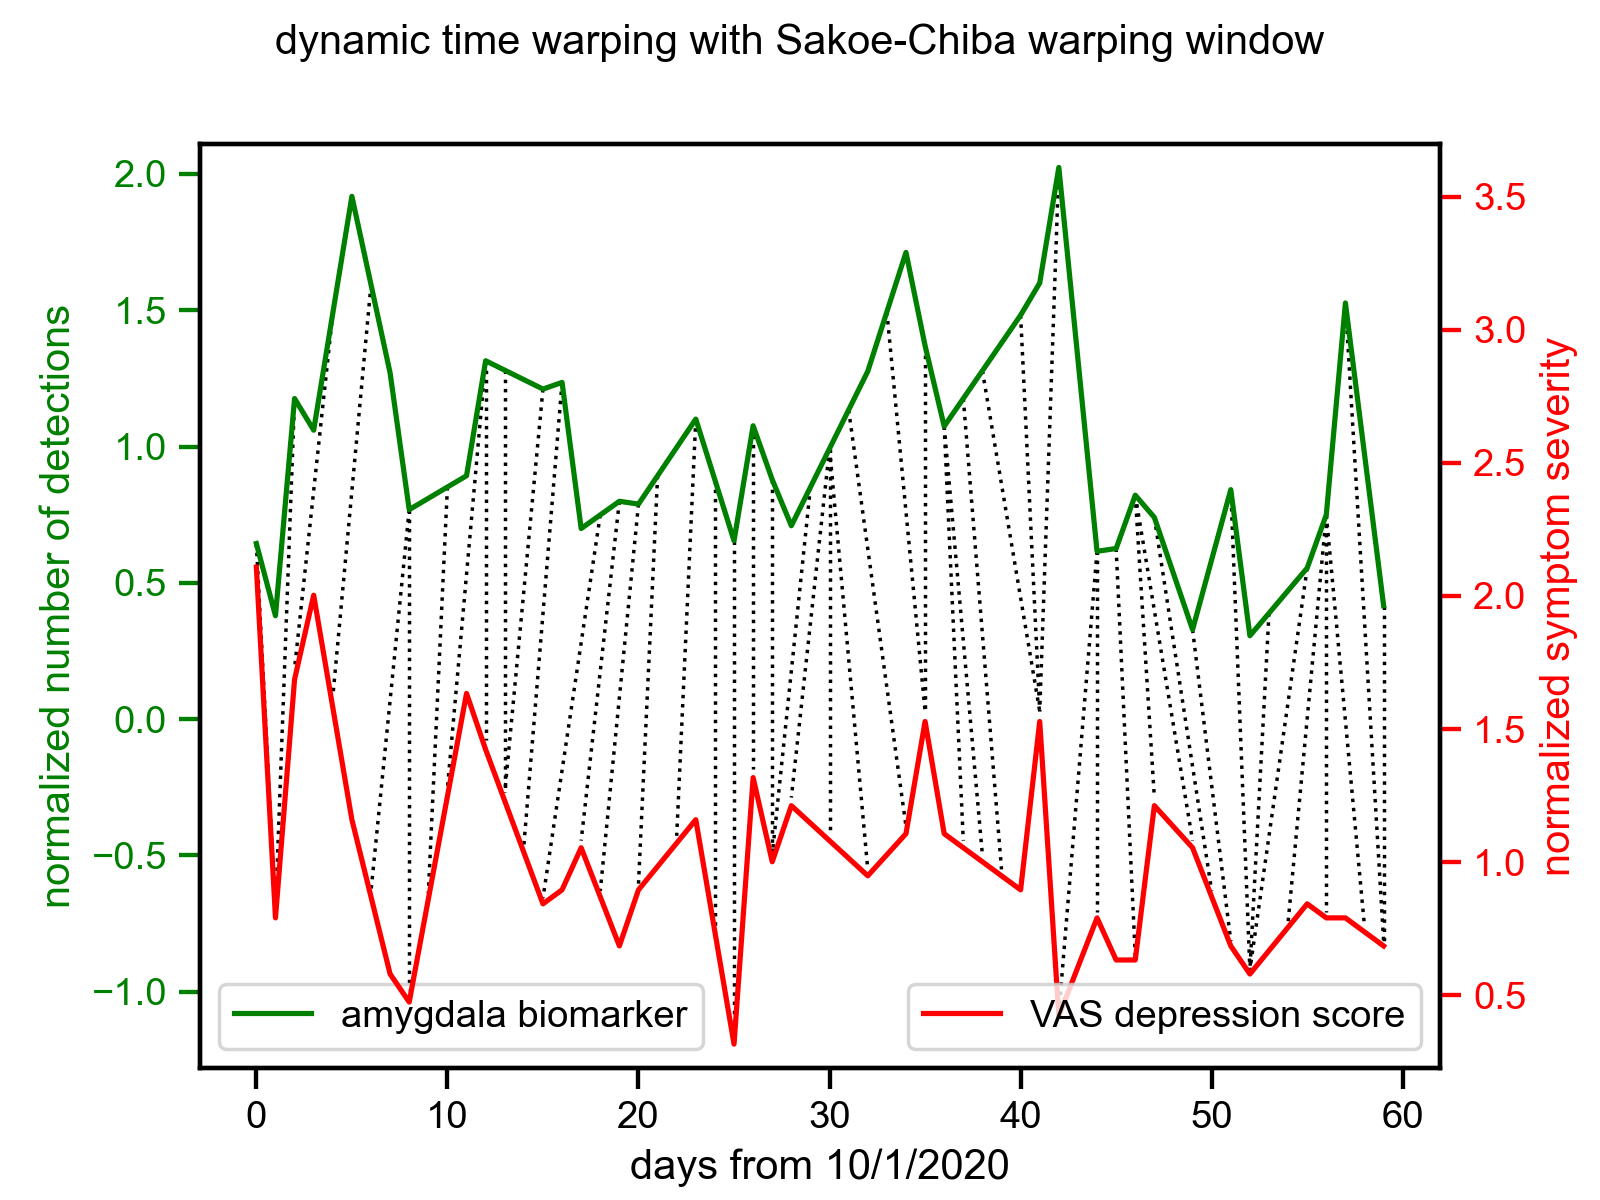

In [10]:
### plot Depression to A1+A2 sako-echiba mapping
%matplotlib notebook
d = dtw(df_i['A1+A2_norm'], df_i['vas_depression_norm'], keep_internals=True, 
         window_type = 'sakoechiba', window_args = {'window_size': 3}) #,step_pattern=rabinerJuangStepPattern(6, "c")
offset=-1.5
ts_type="l"
match_indices=None
match_col="black"
xlab="Index"
ylab="Query value"
# plotting code from here:
# https://github.com/DynamicTimeWarping/dtw-python/blob/9f14e46b6d00c7ea5d8bc3ed1638c9c98ecd366b/dtw/dtwPlot.py
xts = d.query
yts = d.reference
offset = -offset

maxlen = max(len(xts), len(yts))
times = numpy.arange(maxlen)
xts = np.pad(xts,(0,maxlen-len(xts)),"constant",constant_values=np.nan)
yts = np.pad(yts,(0,maxlen-len(yts)),"constant",constant_values=np.nan)

fig, ax = plt.subplots()
if offset != 0:
    ax2 = ax.twinx()
    ax2.tick_params('y', colors='red')
    ax.tick_params('y', colors='green')
else:
    ax2 = ax
    
ax.plot(times, xts, color='green', label = 'amygdala biomarker')
ax2.plot(times, yts, color='red', label = 'VAS depression score')
ax.set(xlabel = 'days from 10/1/2020', ylabel = 'normalized number of detections')
ax.yaxis.label.set_color('green')
ax2.set(ylabel = 'normalized symptom severity')
ax2.yaxis.label.set_color('red')

ql, qh = ax.get_ylim()
rl, rh = ax2.get_ylim()

if offset > 0:
    ax.set_ylim(ql - offset, qh)
    ax2.set_ylim(rl, rh + offset)
elif offset < 0:
    ax.set_ylim(ql, qh - offset)
    ax2.set_ylim(rl + offset, rh)
    
# https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
if match_indices is None:
    idx = numpy.linspace(0, len(d.index1) - 1)
elif not hasattr(match_indices, "__len__"):
    idx = numpy.linspace(0, len(d.index1) - 1, num=match_indices)
else:
    idx = match_indices
idx = numpy.array(idx).astype(int)

col = []
for i in idx:
    col.append([(d.index1[i], xts[d.index1[i]]),
                (d.index2[i], -offset + yts[d.index2[i]])])
    
lc = mc.LineCollection(col, linewidths=1, linestyles=":", colors=match_col)
ax.add_collection(lc)
ax.legend(loc= 'lower left')
ax2.legend(loc = 'lower right')
plt.suptitle('dynamic time warping with Sakoe-Chiba warping window')
plt.savefig('DTW_A1A2_depr.pdf', format='pdf', transparent=True)
plt.show()

### evaluate likelihood of DTW mapping

In [12]:
def dist(t1, t2):
    alignment = dtw(t1, t2, window_type = 'sakoechiba', 
                    window_args = {'window_size': 3}, keep_internals=True) #step_pattern=rabinerJuangStepPattern(7, "c"),
    return alignment.distance

In [14]:
%%time
# shuffled biomarker count vs mood scores distance histogram
# DEPRESSION: circular permutation for normalized, RJ+Sako Echiba, depression
num_iters = 10000
shuff_dep = []
distance_anx = []

# first element is baseline 
shuff_dep.append(dist(df_i['A1+A2_norm'], df_i['vas_depression_norm']))
for i in range(num_iters):
    if i%5000==1: 
        print(f'iteration {i}')
    query = df_i['A1+A2_norm'].sample(frac=1)
    shuff_dep.append(dist(query, df_i['vas_depression_norm']))

iteration 1
iteration 5001
CPU times: user 27.4 s, sys: 52 ms, total: 27.5 s
Wall time: 27.5 s


In [ ]:
# change to probability density
%matplotlib notebook

fig, axs = plt.subplots(1,1, figsize=(7,4), sharey=True)

# calculate the proportional area under the "curve" to the left of the unshuffled value
p_val = len([val for val in shuff_dep if val <= shuff_dep[0]]) / len(shuff_dep)

axs.hist(shuff_dep, bins = 100, color = 'royalblue')
axs.axvline(shuff_dep[0], color= 'red', ls = 'dashed', label = f'unshuffled distance \np-value = {str(round(p_val,7))}')
axs.set(ylabel='frequency', xlabel='time-warped global distance',
        title='DTW distance from depression trace to \n10,000 shuffled amygdala biomarker traces')
axs.legend(frameon = False)
#plt.savefig('DTW_shuff_dist_A1A2_depr.pdf', format='pdf', transparent=True)